# Time Series Analysis

In [1]:
from financial.data import DataStore

ds = DataStore(path="../data")
print(ds)

DataStore with 679 data sources


In [2]:
metadata = ds.metadata.get_metadata('^GSPC')
print(metadata)

{'ticker': '^GSPC', 'description': 'S&P 500', 'category': 'stocks', 'source': 'Yahoo', 'id': None, 'url': 'https://fred.stlouisfed.org/series/SP500', 'isin': None, 'frequency': 'daily', 'since': Timestamp('1927-12-30 00:00:00')}


In [6]:
data = ds.get_data('^GSPC')
print(data)

Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2022-02-18    4348.870117
2022-02-22    4304.759766
2022-02-23    4225.500000
2022-02-24    4288.700195
2022-02-25    4384.649902
Name: ^GSPC, Length: 23652, dtype: float64


In [13]:
data = ds.get_data('^GSPC','1980-01-01')
print(data)

Date
1980-01-02     105.760002
1980-01-03     105.220001
1980-01-04     106.519997
1980-01-07     106.809998
1980-01-08     108.949997
                 ...     
2022-02-18    4348.870117
2022-02-22    4304.759766
2022-02-23    4225.500000
2022-02-24    4288.700195
2022-02-25    4384.649902
Name: ^GSPC, Length: 10630, dtype: float64


## Plot data

<AxesSubplot:xlabel='Date'>

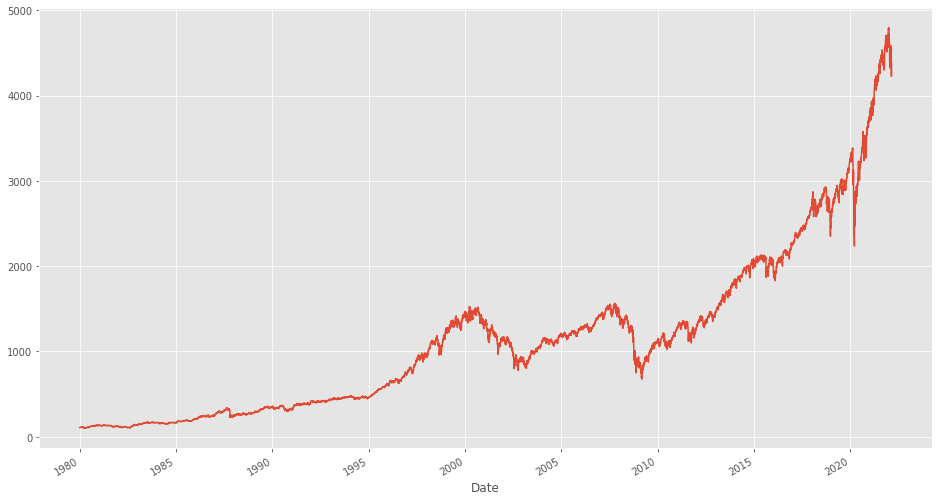

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
mpl.style.use('ggplot')

data.plot(label='S&P')


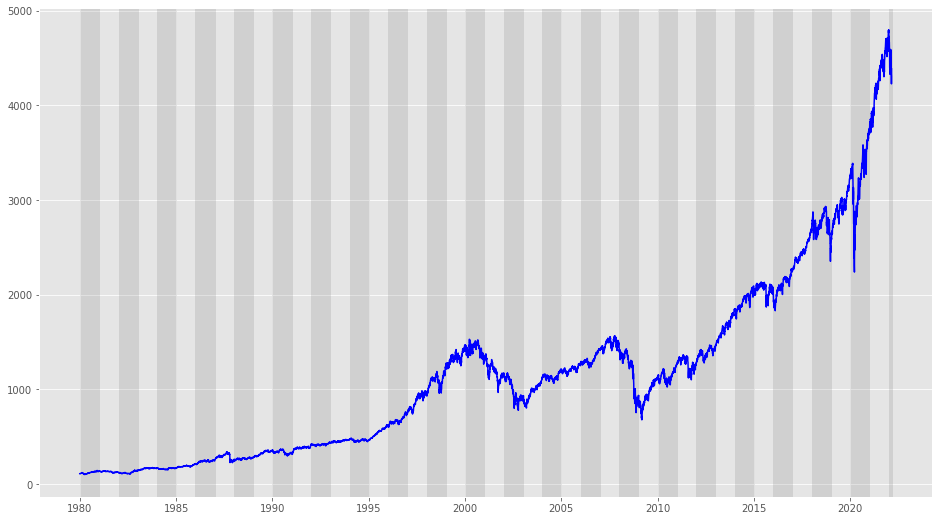

In [18]:
fig, ax = plt.subplots()
ax.plot(data,'blue')

for yr in range(1980,2023,2):
    year = data.loc[str(yr)+'-01-01':str(yr)+'-12-31']
    first_date = year.index[0] #.strftime('%Y-%m-%d')
    last_date = year.index[-1] #.strftime('%Y-%m-%d')
    first_date_loc = data.index.get_loc(first_date)
    last_date_loc = data.index.get_loc(last_date)
    #print(first_date)
    #print(last_date)
    ax.axvspan(data.index[first_date_loc], data.index[last_date_loc], alpha=0.2, color='gray')

plt.show()

## Trend & Seasonality

In [19]:
import pandas as pd

variable = '^GSPC'
lookahead = 52

df = pd.DataFrame(data)
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df

,^GSPC,year,month,day
Date,,,,
1980-01-02,105.760002,1980,1,2
1980-01-03,105.220001,1980,1,3
1980-01-04,106.519997,1980,1,4
1980-01-07,106.809998,1980,1,7
1980-01-08,108.949997,1980,1,8
...,...,...,...,...
2022-02-18,4348.870117,2022,2,18
2022-02-22,4304.759766,2022,2,22
2022-02-23,4225.500000,2022,2,23


<AxesSubplot:xlabel='month'>

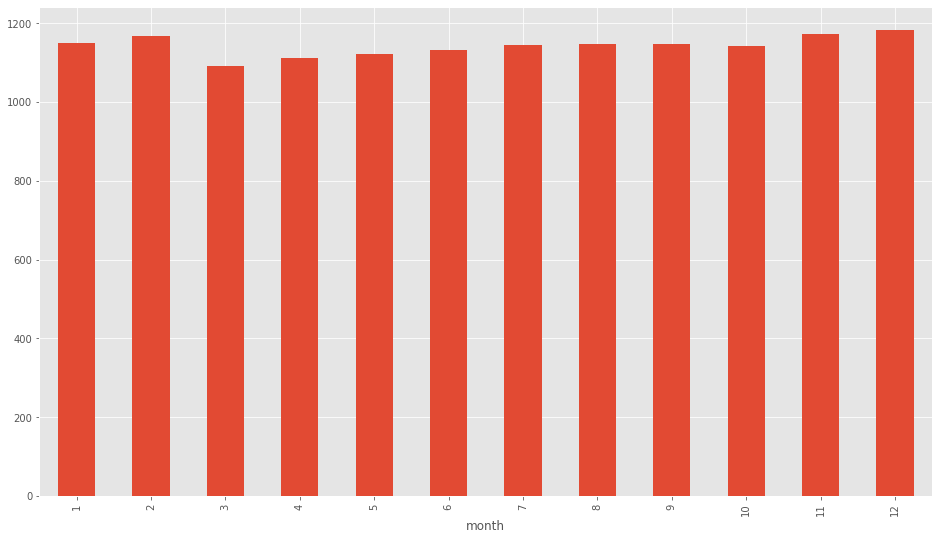

In [21]:
df.groupby('month')[variable].mean().plot.bar()

<AxesSubplot:xlabel='year'>

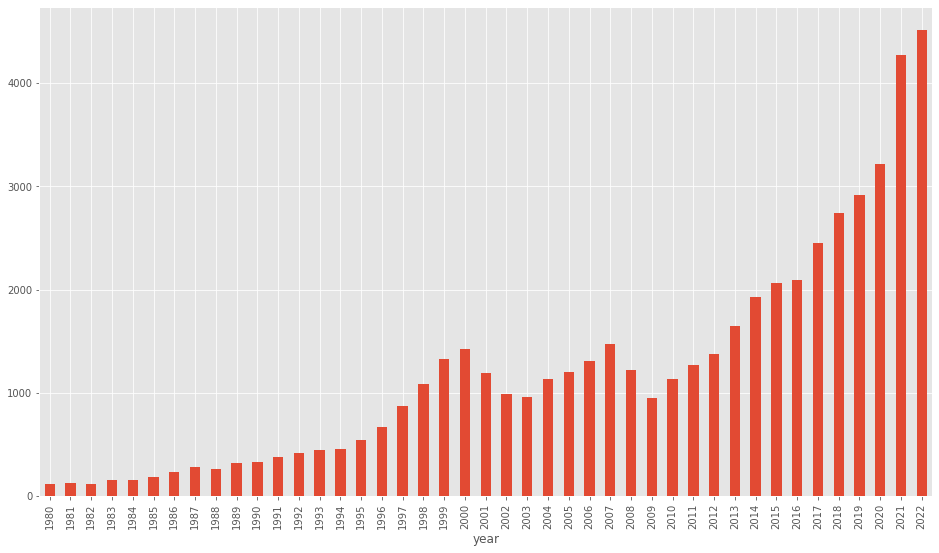

In [22]:
# Upward trend
df.groupby('year')[variable].mean().plot.bar()

In [23]:
monthly = df.resample('M').mean()
monthly

,^GSPC,year,month,day
Date,,,,
1980-01-31,110.868181,1980.0,1.0,16.681818
1980-02-29,115.339001,1980.0,2.0,15.650000
1980-03-31,104.686191,1980.0,3.0,16.238095
1980-04-30,102.966668,1980.0,4.0,15.857143
1980-05-31,107.694285,1980.0,5.0,15.571429
...,...,...,...,...
2021-10-31,4460.707078,2021.0,10.0,15.761905
2021-11-30,4667.386649,2021.0,11.0,14.476190
2021-12-31,4674.772772,2021.0,12.0,16.000000


<AxesSubplot:xlabel='Date'>

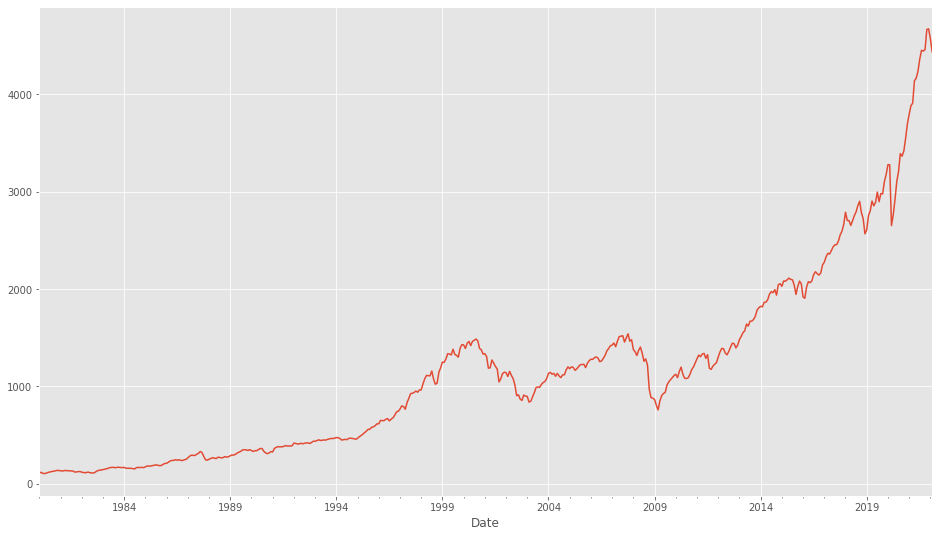

In [24]:
monthly[variable].plot(label='Montly S&P')

### Stationarity

A time series is stationary if it satisfies the following three conditions.
1. Mean of the series over time is constant
2. Variance of the series over time is constant.
3. No seasonality.

In [25]:
# Dickey Fuller test 

from statsmodels.tsa.stattools import adfuller

def dftest(series):
    dftest = adfuller(series, autolag='AIC')
    print(dftest)

    dfoutput = pd.Series(dftest[0:4], index=['Test statistic', 'p-value', '#lags used', '#observations'])

    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)'%key] = value
        
    return dfoutput

print('Dickey-Fuller test')
dfoutput = dftest(data)
print(dfoutput)

Dickey-Fuller test
(2.6598825929197543, 0.9990838450641839, 39, 10590, {'1%': -3.4309676473832433, '5%': -2.861812965077259, '10%': -2.56691529416905}, 88860.54361168583)
Test statistic              2.659883
p-value                     0.999084
#lags used                 39.000000
#observations           10590.000000
Critical value (1%)        -3.430968
Critical value (5%)        -2.861813
Critical value (10%)       -2.566915
dtype: float64


According to DF test, the null hypothesis is that the given time series is not stationary. A high p-value supports the null hypothesis.

In [26]:
# First order differencing (for removing the trend)

diff = data.diff()[1:]
diff

Date
1980-01-03    -0.540001
1980-01-04     1.299996
1980-01-07     0.290001
1980-01-08     2.139999
1980-01-09     0.100006
                ...    
2022-02-18   -31.389648
2022-02-22   -44.110352
2022-02-23   -79.259766
2022-02-24    63.200195
2022-02-25    95.949707
Name: ^GSPC, Length: 10629, dtype: float64

<AxesSubplot:xlabel='Date'>

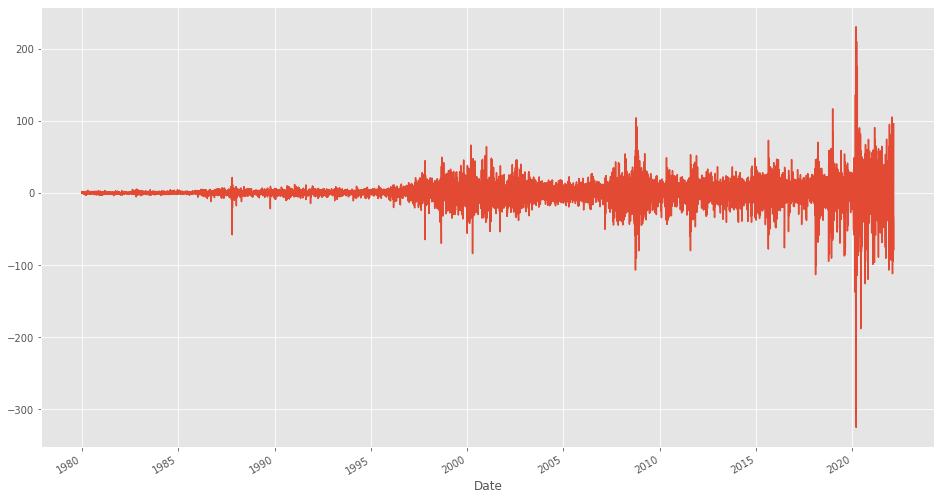

In [27]:
diff.plot(label='diff(S&P)')

In [28]:
dftest(diff)


(-16.28297624195169, 3.3975284885066094e-29, 38, 10590, {'1%': -3.4309676473832433, '5%': -2.861812965077259, '10%': -2.56691529416905}, 88858.25876592647)


Test statistic         -1.628298e+01
p-value                 3.397528e-29
#lags used              3.800000e+01
#observations           1.059000e+04
Critical value (1%)    -3.430968e+00
Critical value (5%)    -2.861813e+00
Critical value (10%)   -2.566915e+00
dtype: float64

The p-value is significantly low now, indicating that the differenced time series might be stationary.

## Time series decomposition

Break up the trend, seasonality, residual (noise) components separately...

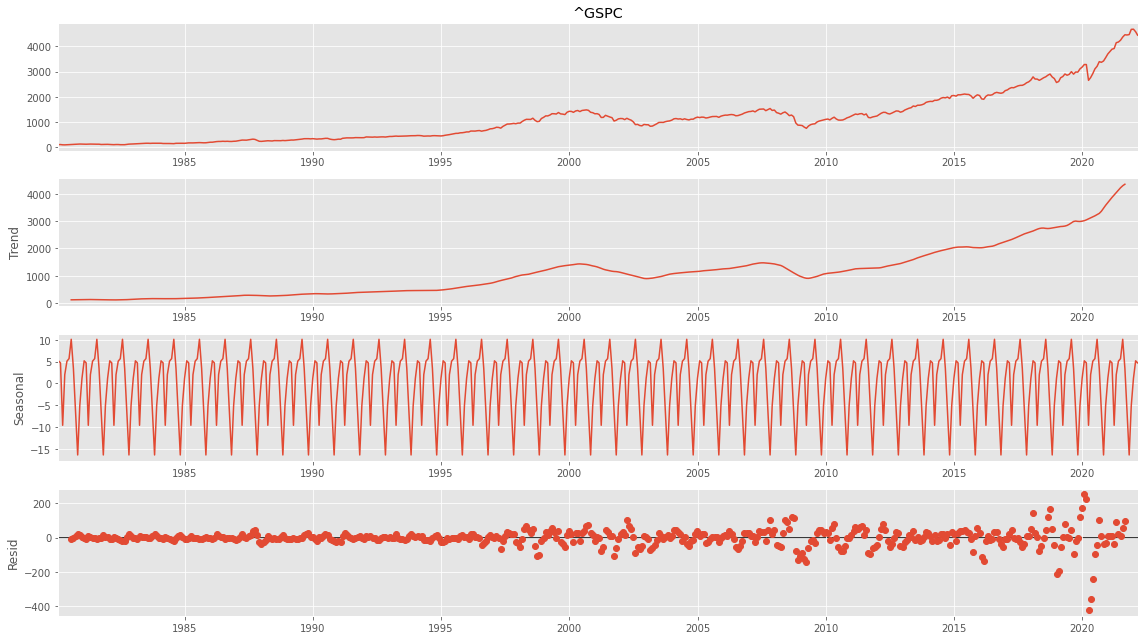

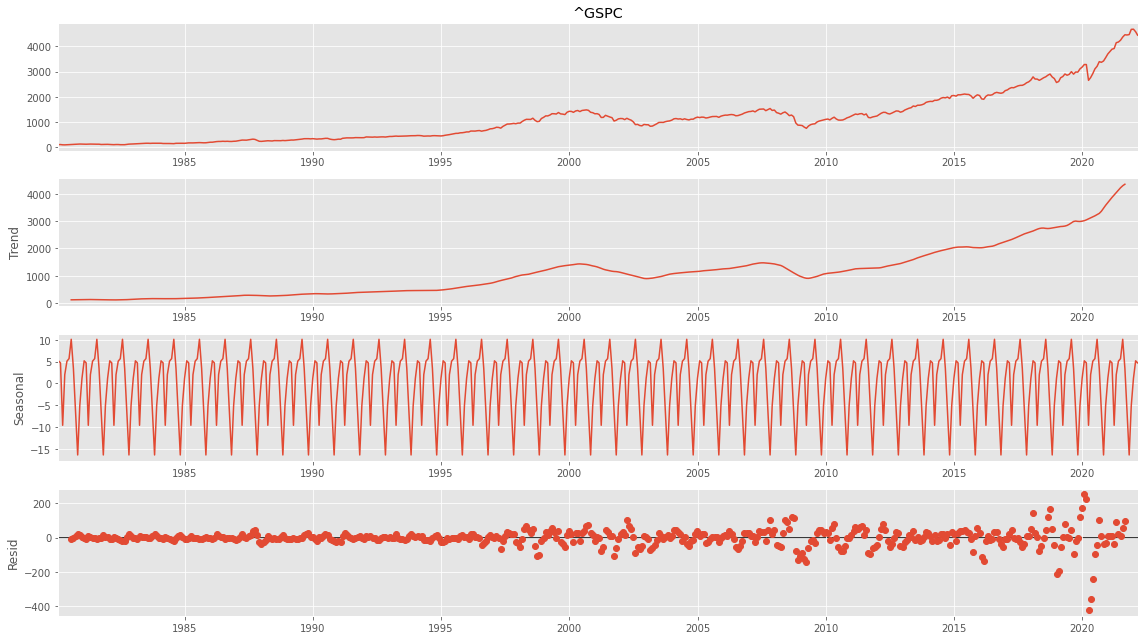

In [33]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(monthly[variable], period=12)

decomposition.plot()


<AxesSubplot:xlabel='Date'>

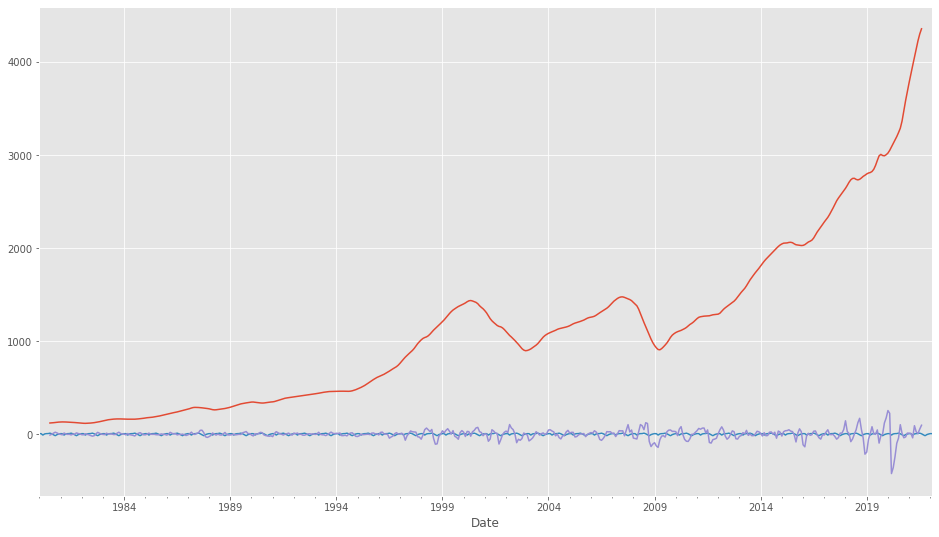

In [34]:
decomposition.trend.plot()
decomposition.seasonal.plot()
decomposition.resid.plot()

# SARIMA

Seasonal ARIMA ( Seasonal Auto Regressive Integrated Moving Average )

2 sets of parameters: Non-seasonal (p,d,q) and Seasonal (P,D,Q,m).

- S: Seasonality
- AR: Auto-regressive (the value at any time step t can be calculated as a regression involving the values of the same series in one or more previous time steps). The number of these time steps is referred as AR lags ( denoted by p parameter ).
- I: Integrated (differencing is done for removing the trend and to achieve stationarity, order of differencing d=1)
- MA: Moving average (the value at any time step t can be calculated as a regression involving the errors (in forecast) seen for previous time steps. The number of these time steps is referred as MA lags (denoted by q parameter).

The parameters (P,D,Q) are seasonal counterparts of p,q and d, whereas m is the number of time steps in which there is a repetition of seasonality 

## ACF & PACF analysis

For determining p and q, we need to plot PACF (Partial Auto Correlation Function ) and ACF ( Auto Correlation Function), respectively.

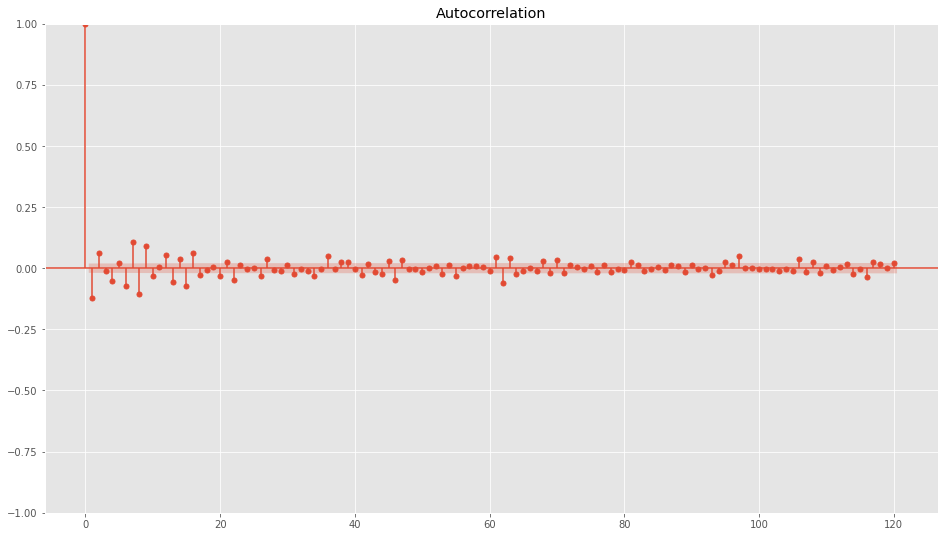

In [38]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(diff, lags=120)

Each From ACF it appears lags 1 (t-1) and 2 (t-2) are significant for MA (q parameter).stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is the correlation of a time step’s value with itself ). From ACF it appears lags 1 (t-1), 2 (t-2), and 3 (t-3) are significant for MA (q parameter).

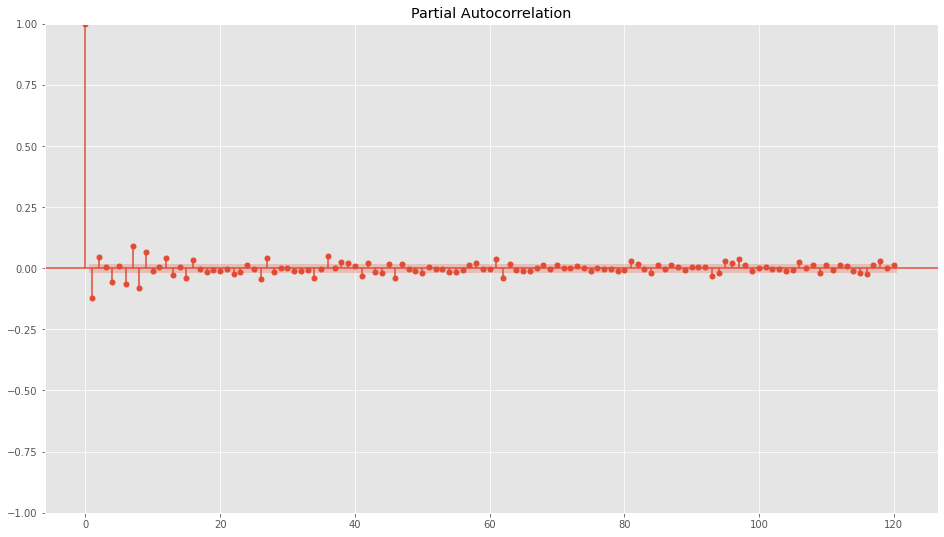

In [39]:
pacf_plot = plot_pacf(diff, method='ywm', lags=120)

Each stick in the plot corresponds to lags starting from 0 ( which has the maximum correlation of 1 as it is correlation of a time step’s value with itself ). From PACF, it appears lags 1 (t-1) and 2 (t-2) are significant for AR (p parameter). 

PS: A far away significant lag might indicate a seasonal pattern.

## Split time series


In [40]:
train = data[:'2020-12-31']
print(train)
test = price['2021-01-01':]
print(test)

Date
1980-01-02     105.760002
1980-01-03     105.220001
1980-01-04     106.519997
1980-01-07     106.809998
1980-01-08     108.949997
                 ...     
2020-12-24    3703.060059
2020-12-28    3735.360107
2020-12-29    3727.040039
2020-12-30    3732.040039
2020-12-31    3756.070068
Name: ^GSPC, Length: 10340, dtype: float64
Date
2021-01-04    3700.649902
2021-01-05    3726.860107
2021-01-06    3748.139893
2021-01-07    3803.790039
2021-01-08    3824.679932
                 ...     
2022-02-18    4348.870117
2022-02-22    4304.759766
2022-02-23    4225.500000
2022-02-24    4288.700195
2022-02-25    4384.649902
Name: ^GSPC, Length: 290, dtype: float64


## Baseline model: Holt-Winters

i.e. exponential smoothing

c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


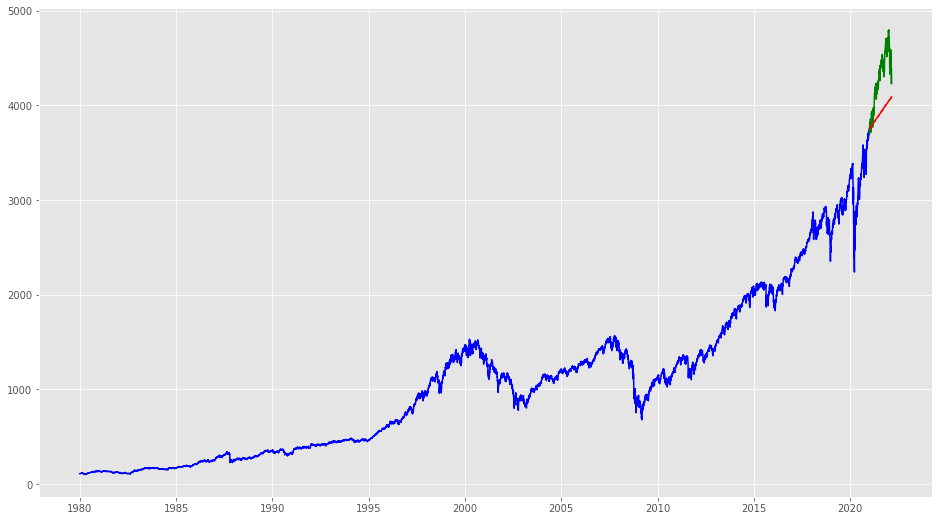

In [41]:
from statsmodels.tsa.api import ExponentialSmoothing

hw = ExponentialSmoothing(train, seasonal_periods=52, trend='add', seasonal='add')
hw_fit = hw.fit()
hw_forecast = hw_fit.forecast(len(test))
hw_forecast.index = test.index

plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(hw_forecast,'r')

In [42]:
import numpy as np

hw_residuals = hw_forecast - test

print('MAPE (Mean Absolute Percent Error)')
np.mean(abs(hw_residuals/test))

MAPE (Mean Absolute Percent Error)


0.08699709308906885

## ARIMA(p,q)

d=1 (first-order differencing)

p=2 (PACF analysis)

q=3 (ACF analysis)

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# order (p,d,q)
order = (10,1,10)

model = ARIMA(train, order=order)
model_fit = model.fit()

predictions = model_fit.forecast(len(test))
predictions.index = test.index

residuals = test - predictions


c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\software\python38\lib\site-pa

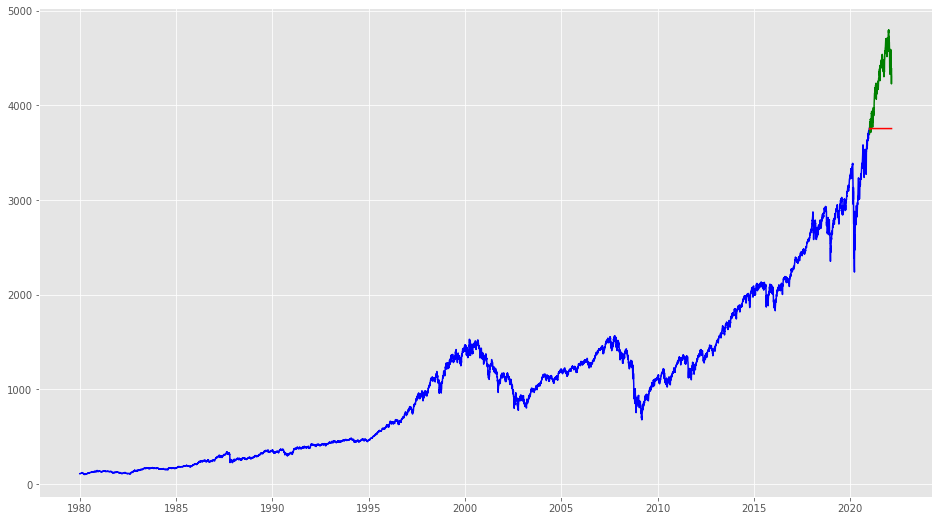

In [48]:
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(predictions,'r')

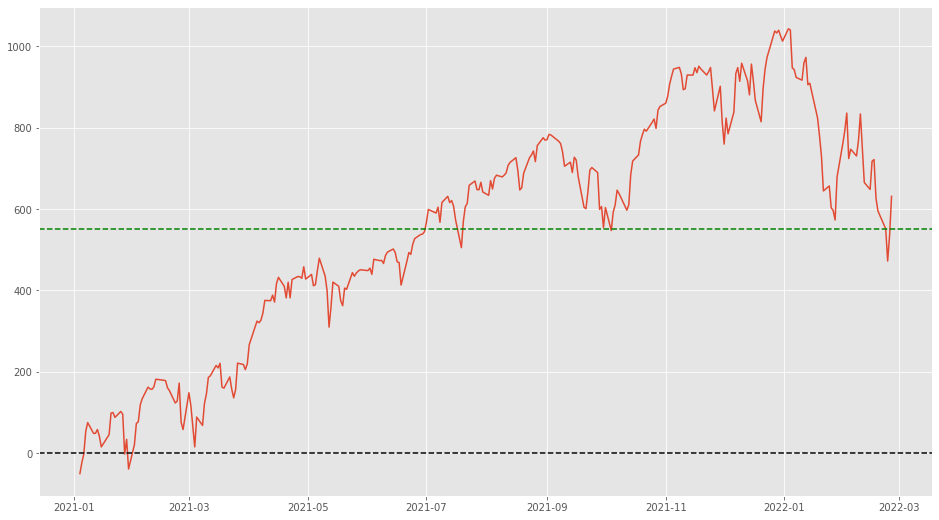

In [49]:
# Residuals (ideally, residuals should have 0 mean)

plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.axhline(residuals.mean(), linestyle='--', color='g')

In [50]:
import numpy as np

print('MAPE (Mean Absolute Percent Error)')
np.mean(abs(residuals/test))

MAPE (Mean Absolute Percent Error)


0.12438354580077797

## SARIMA

d=1 (first-order differencing)

p=2 (PACF analysis)

q=3 (ACF analysis)

m=52 (seasonality)

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# order (p,d,q)
order = (5,1,5)
# seasonal
seasonal_order = (0,1,0,5)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

predictions = model_fit.forecast(len(test))
predictions.index = test.index

residuals = test - predictions

c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\software\python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\software\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


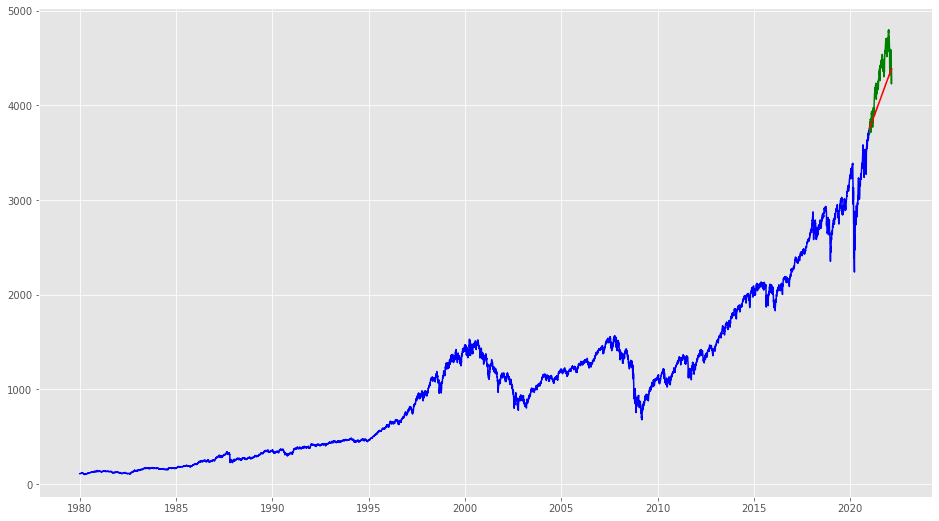

In [53]:
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(predictions,'r')

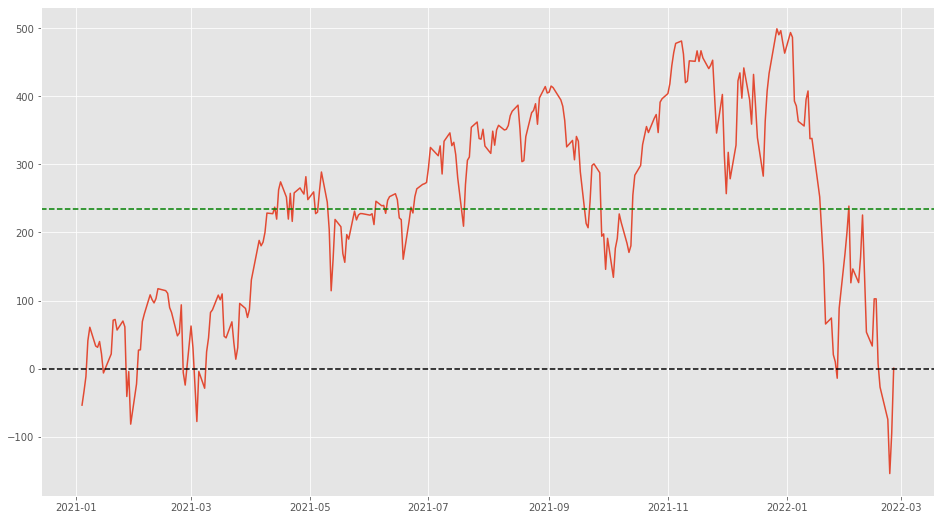

In [54]:
# Residuals (ideally, residuals should have 0 mean)

plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.axhline(residuals.mean(), linestyle='--', color='g')

In [55]:
import numpy as np

print('MAPE (Mean Absolute Percent Error)')
np.mean(abs(residuals/test))

MAPE (Mean Absolute Percent Error)


0.0540861768708074

# AutoARIMA

In [ ]:
from pmdarima import auto_arima

sarimax_model = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3, m=52, test='adf', seasonal=True, d=1, D=1, trace=True, error_action='ignore', supress_warnings=True, stepwise=True)

sarimax_model.summary()

The best model chosen by Auto ARIMA after a few minutes is...

ARIMA(3,1,0)(2,1,0)[52]

p=3, d=1, q=0

P=2, D=1, Q=0, m=52

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# order (p,d,q)
order = (3,1,0)
# seasonal
seasonal_order = (2,1,0,52)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

predictions = model_fit.forecast(len(test))
predictions.index = test.index

residuals = test - predictions

In [ ]:
plt.plot(train,'b')
plt.plot(test,'g')
plt.plot(predictions,'r')

In [ ]:
# Residuals (ideally, residuals should have 0 mean)

plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.axhline(residuals.mean(), linestyle='--', color='g')

In [ ]:
import numpy as np

print('MAPE (Mean Absolute Percent Error)')
np.mean(abs(residuals/test))